In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus'] = False  

import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [13]:
np.random.seed(3)
tf.random.set_seed(3)
random.seed(42)

In [15]:
train_datagen=ImageDataGenerator(rescale=1/255.0,
                                 horizontal_flip=True,    # 뒤집기 (좌우)
                                 width_shift_range=0.1,   # 왼쪽 또는 오른쪽으로 무작위 이동
                                 height_shift_range=0.1,  # 왼쪽 또는 오른쪽으로 무작위 이동
                                 fill_mode='nearest')     # 이동이나 변형으로 인해 생긴 빈 픽셀을 가장 가까운 값으로 채움

train_generator=train_datagen.flow_from_directory('./Data/face/real_and_fake_face', 
                                                  target_size=(299, 299),
                                                  batch_size=5,          # 한 번에 가져오는 이미지 개수, 이미지 로드
                                                  class_mode='binary',   # 또는 categorical  
                                                  subset='training')  
train_generator.class_indices

Found 2042 images belonging to 2 classes.


{'training_fake': 0, 'training_real': 1}

In [17]:
test_datagen=ImageDataGenerator(rescale=1/255.0)

test_generator=test_datagen.flow_from_directory('./Data/face/real_and_fake_face_detection/real_and_fake_face',
                                                target_size=(299, 299),
                                                batch_size=5,
                                                class_mode='binary')
test_generator.class_indices

Found 2041 images belonging to 2 classes.


{'training_fake': 0, 'training_real': 1}

In [19]:
# Xception 모델 구성
transfer_model=Xception(weights='imagenet', 
                        include_top=False, 
                        input_shape=(299, 299, 3))

transfer_model.trainable=False   # Xception 모델의 가중치가 학습 중에 업데이트되지 않도록 설정
transfer_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 149, 149, 32)      │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 149, 149, 32)      │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 147, 147, 64)      │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 147, 147, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 147, 147, 64)      │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 147, 147, 128)     │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 147, 147, 128)     │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 147, 147, 128)     │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 147, 147, 128)     │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 74, 74, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 74, 74, 128)       │               

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [23]:
# Xception 신경망에 사용자 계층 추가 
model=keras.Sequential()
model.add(transfer_model)

# 완전층
model.add(keras.layers.Flatten())
# model.add(GlobalAveragePooling2D())   
model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      13,107,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,968,874 (129.58 MB)

 Trainable params: 13,107,394 (50.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [25]:
model.compile(optimizer=Adam(learning_rate=0.0002),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
history=model.fit(train_generator,
                  epochs=5, 
                  validation_data=test_generator,
                  validation_steps=24)   

C:\Users\JMH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 651s 2s/step - accuracy: 0.5432 - loss: 1.1258 - val_accuracy: 0.6750 - val_loss: 0.6322
Epoch 2/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 665s 2s/step - accuracy: 0.6117 - loss: 0.6612 - val_accuracy: 0.5417 - val_loss: 0.6433
Epoch 3/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.6275 - loss: 0.6417 - val_accuracy: 0.6917 - val_loss: 0.6368
Epoch 4/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 4202s 10s/step - accuracy: 0.6578 - loss: 0.6217 - val_accuracy: 0.7000 - val_loss: 0.5963
Epoch 5/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.6643 - loss: 0.6083 - val_accuracy: 0.6833 - val_loss: 0.5736


In [42]:
print(model.evaluate(test_generator))

409/409 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6908 - loss: 0.5862
[0.5882835388183594, 0.7045565843582153]


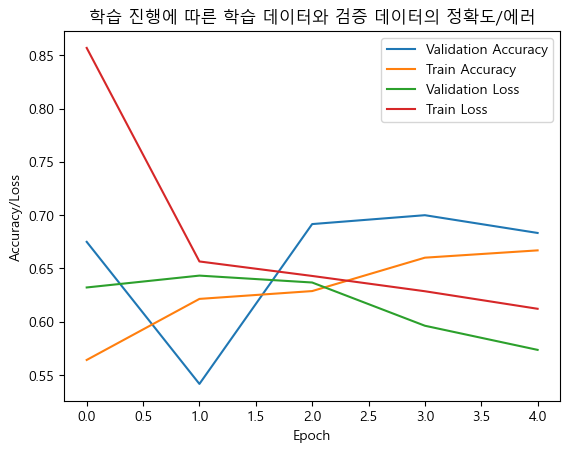

In [44]:
# 그래프로 표현
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.legend(loc='best')

plt.title('학습 진행에 따른 학습 데이터와 검증 데이터의 정확도/에러')
plt.show()

In [46]:
steps=test_generator.n // 5   # 한 번에 가져오는 이미지 개수 (배치 크기)
print(steps)                  # 121/5=24 

images, labels=[],[]

for i in range(steps):
    img, lab=next(test_generator)
    images.extend(img)      # images 리스트에 하나씩 넣기
    labels.extend(lab)

images=np.asarray(images)   # 리스트 → NumPy 배열
labels=np.asarray(labels).astype(int)
labels[0]

408


1

In [47]:
# 예측 확률
pred_prob=model.predict(images)

64/64 ━━━━━━━━━━━━━━━━━━━━ 423s 6s/step


In [50]:
pred_prob[0]

array([0.27042747, 0.7295726 ], dtype=float32)

In [52]:
# 결과 예측 
pred=np.argmax(pred_prob, axis=1)
pred[0]

1

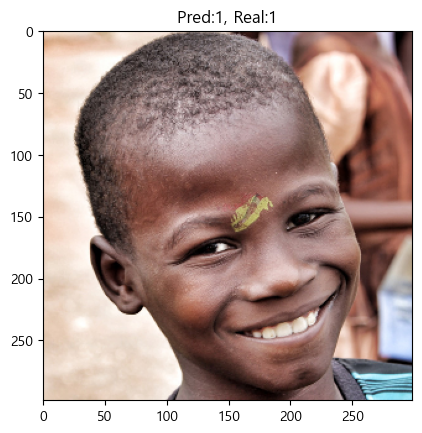

In [54]:
# 결과 확인
plt.imshow(images[0])
plt.title(f'Pred:{pred[0]}, Real:{labels[0]}')
plt.show()

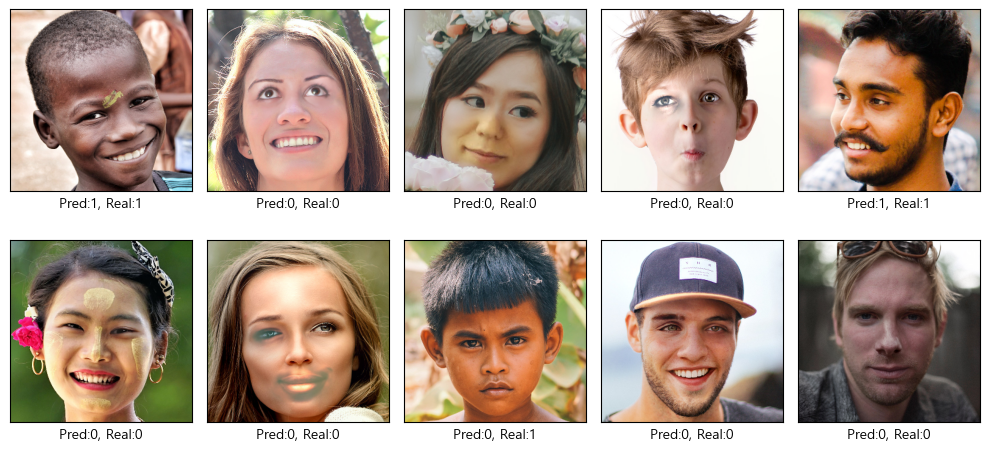

In [56]:
fig, axes=plt.subplots(2, 5, figsize=(10, 5))  # 2x5 그리드로 서브플롯 생성
for ax, img, pre, label in zip(axes.flat, images[:10], pred[:10], labels[:10]):
    ax.imshow(img)        # 이미지를 표시
    ax.set_xlabel(f'Pred:{pre}, Real:{label}')    # 라벨을 x축 레이블로 설정
    
    # ax.axis('off')      #  문제 발생 >> 다 안나옴
    ax.set_xticks([])     # x축 눈금 제거
    ax.set_yticks([])     # y축 눈금 제거
     
plt.tight_layout()  # 레이아웃 간격 자동 조정
plt.show()

In [63]:
# 결과 확인
print(metrics.classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.65      0.79      0.72       959
           1       0.77      0.63      0.69      1081

    accuracy                           0.70      2040
   macro avg       0.71      0.71      0.70      2040
weighted avg       0.72      0.70      0.70      2040

